<a href="https://colab.research.google.com/github/kvmkrao/cdml/blob/master/leaflet_math_model_const.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Parameters​**
Vein Radius $a$​ 

Sinus Length $l$​  

Maximum Sinus Radius $b$ 

Axial Position of Leaflet Edge $zD$  

Leaflet Thickness $t$​  

Vein Wall Thickness $tw$ 

Auxiliary Parameters Relating to the Leaflet  

Thickness Upstream​

​The intersection of the interior leaflet surface with the interior vein wall is completely determined by $a$, $b$ and $l$, plus two auxiliary parameters b and $z1$.​

The geometry of the interior leaflet surface when in the open flowing condition is determined by the following​

Each axial cross section is assumed to be an arc of a circle​ 

The (corrected) flow area is constant 

 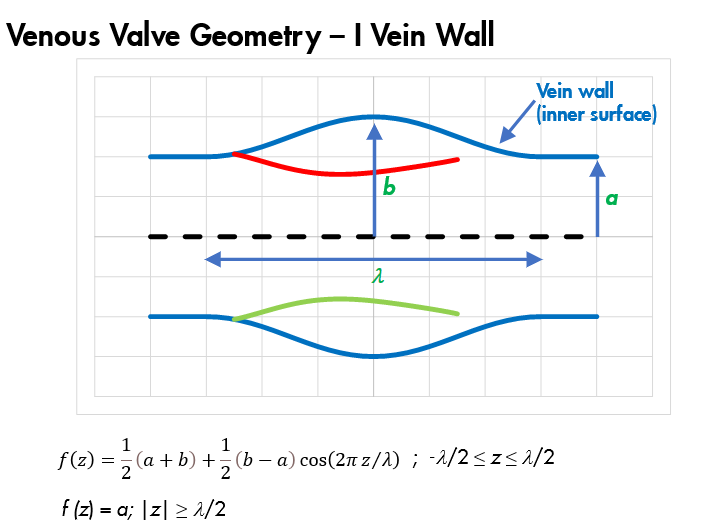

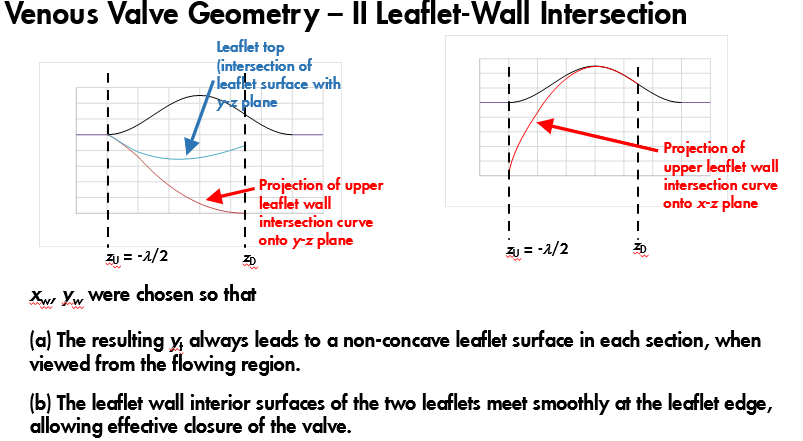

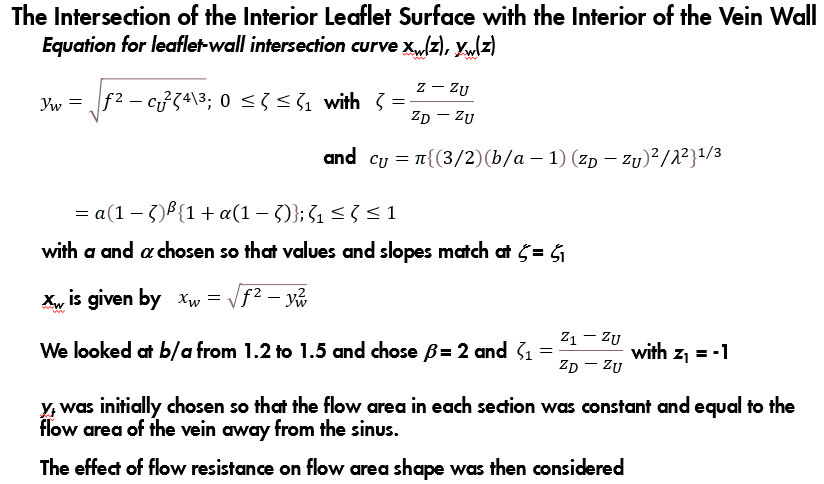

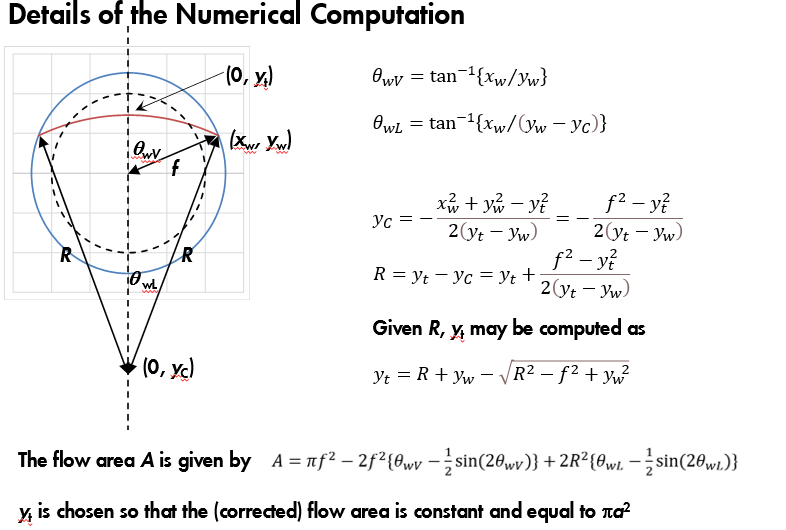

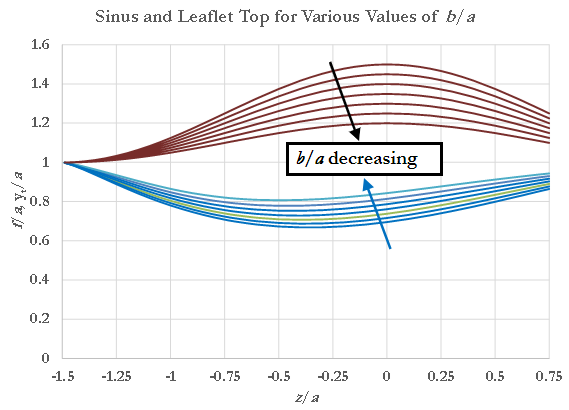

In [37]:
!pip install numpy-stl
import numpy as np
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
import pandas as pd

300
558
nan 1.0001096582625773 1.0285039394106728 1.0001096582625773 nan nan
0.1577524092922526 1.0027390523158632 0.9902523841939513 1.0027390523158632 0.9647118904275273 1.4646658007336
0.3628920079570267 1.0109261996330972 0.9435471221224374 1.0109261996330972 0.9438802155637751 -196.7344647279101
0.49296746954671267 1.0244717418524232 0.8980676053743666 1.0244717418524232 0.915299605211844 -6.144643237884979
0.5994474924960934 1.0432272711786996 0.8538066778089183 1.0432272711786996 0.8863841895419581 -4.645017249031658
0.6936387273463565 1.0669872981077806 0.8107571832852724 1.0669872981077806 0.8586373450500739 -4.189666338007668
0.780305082512802 1.0954915028125263 0.7689119656626087 1.0954915028125263 0.8327594513498557 -3.9673710207129256
0.8619631993842118 1.128427587261303 0.7282638688001066 1.128427587261303 0.8090839934667661 -3.8278331898161477
0.9400982341433788 1.1654346968205709 0.688805736556946 1.1654346968205709 0.7877308876350622 -3.7286679533923306
1.0156304344084

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


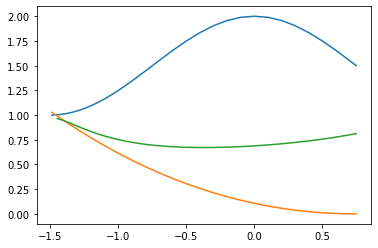

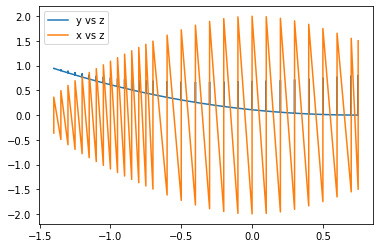

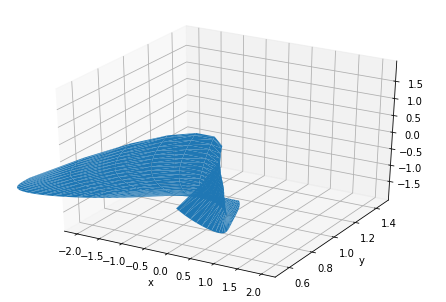

In [38]:
#check alpha and a1
# b/a   = 2.0 ;  beta  = 2 ; zeta1 = 0.222 ; f1    = 1.25 ; G1    = 0.37629 ; H1    = 0.783963 ; alpha  = 0.116926; f11    = 2.040524 ; a1     = 0.92950 

#check yt
#from Dr. Harris 
#z,  b,   zeta,               f,                yw,                 xw,               yt,               yc                  R                   tv                    tl                  FF                  AA              AsF              errl
#-1.4 1,2 0.0044444444444444  1.002              0.978226531        0.217826           0.97930            -21.09633          22.07563            0.00694485            6.40487E-06         0.999733          3.142011          3.141592654       

import math 
import numpy as np
import matplotlib.pyplot as plt
import sys

def fzf(a,b,z,lamda): 
  if abs(z) <= lamda/2:  
    return 0.5*(a+b) +0.5*(b-a)*math.cos(2*math.pi*z/lamda); 
  elif abs(z) >= lamda/2: 
    return a

zetaf = lambda z, zU, zD: (z-zU)/(zD-zU)

def cUf(b,a,zD,zU,lamda): 
  return math.pi*a*(((1.5)*(b/a-1.0)*(zD-zU)**2)/(lamda**2))**(1.0/3.0) 

def ywf(zeta, zeta1, fn, cu, a,alpha, beta): 
  if zeta>=0 and zeta <=zeta1: 
    return math.sqrt(fn*fn-cu*cu*zeta**(4.0/3))
  elif zeta>= zeta1 and zeta<=1: 
    return (a*(1.0-zeta)**beta)*(1+alpha*(1.0-zeta)) 

xwf = lambda fn,yw: (fn*fn-yw*yw)**0.5

ycf = lambda fn,yt,yw: -(fn*fn - yt*yt)/(2*(yt-yw))
  
Rf = lambda yt,fn,yw: yt + (fn**2 - yt**2)/(2*(yt-yw))

def arf(a,fz,xw,yw,yt): 
  yc  = ycf(fz,yt,yw)
  twv = math.atan(xw/yw)
  twl = math.atan(xw/(yw-yc))
  R   = Rf(yt,fz,yw)
  Area = math.pi*a*a 
  tmp1 = twv-0.5*math.sin(2*twv)
  tmp2 = twl-0.5*math.sin(2*twl)
  Area1 = math.pi*fz**2 - (2.*fz**2)*tmp1 + 2*(R**2)*tmp2
  return Area - Area1

def rtwl(xw,yw, f, yt):
  yc = ycf(f,yt,yw)
  R  = yt - yc  #Rf(yl,f,yw)
  twl = math.atan(xw/(yw-yc))
  return yc, R, twl

def err(xw,yw, f, yt):
  yc = ycf(f,yt,yw)
  R  = yt - yc  #Rf(yl,f,yw)
  tv =  math.asin(xw/f) - (xw/f)*(1-(xw/f)**2)**0.5 
  tl = math.asin(xw/R) - (xw/R)*(1-(xw/R)**2)**0.5
  FF = 2.0*(yt/f)/(1+(yt/f)**2)
  AA = math.pi*f*f-2*f*f*tv+2*R*R*tl
  AsF = AA*FF**0.5 
  errl = AsF - math.pi
  return errl 

def BiSection(xL,xU, xw, yw, f, n): 
  for i in range(n):
    xR = (xL+xU)/2; #print('BiSection',[xL,xR,xU])
    if (err(xw,yw, f,xL)*err(xw, yw, f,xR)>0): xL = xR
    else: xU = xR
    if abs(err(xw, yw, f,xR))< 1e-10:
      return xR
  return xR; 
  
def shootingM(xL,xU, xw, yw, f, n):
  yi   = np.zeros(n)
  yi[0] = 0.99*yw + 0.01*f
  yi[1] = f
  for i in range(2,n): 
    errl  = err(xw,yw, f, yi[i-2])
    erru  = err(xw,yw, f, yi[i-1])
    yi[i] = (erru * yi[i-2] - errl*yi[i-1])/(erru-errl) 
    if abs(err(xw,yw, f, yi[i])) <1e-12: 
      return yi[i] 
  return yi[i]


a     = 1   #vein radius   (mm)
L     = 3   #sinus length (lambda)
b     = 2.0 #maximum sinus radius (must be larger than one for the leaflets to seal well in 
            # [1.2,1.5]                      (the closed position and I have chosen b = 2)
t     = 0.05 #leaflet thickness (50mu m)
tw    = 0.1 #vein wall thickness (100 mu m)
beta  =  2  #aux variable 1 
z1    = -1  #aux variable 2 
zU    = -L/2; # -lambda/2 
zD    =  L/4 ; #[0,l/2]  #axial position of leaflet edge
zeta1 = zetaf(z1, zU, zD) #2/9 
cu    = cUf(b,a,zD,zU,L)

ndiv = 10; 
#zs = np.array([-0.3, 0.3]) #np.linspace(zU,zD,n) 
zs = np.array([-1.49, -1.45, -1.4, -1.35, -1.3, -1.25, -1.2, -1.15, -1.1, -1.05, -1,-0.95, -0.9, -0.85,\
-0.8, -0.75, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.749]) 
n = len(zs) 
fas  = np.zeros(n)
yts  = np.zeros(n) 
ycs  = np.zeros(n)
yws  = np.zeros(n)
a1s  = np.zeros(n)
xws  = np.zeros(n)

npoints = ndiv*(n-2)
print(npoints)
#sys.exit() 

point= np.zeros([npoints,3])

nelem  = (ndiv-1)*(n-1)*2  # no of triangular elements 
print(nelem)
face  = np.zeros((nelem, 3), dtype=int) 

m = 0; 
for i in range(n): 
  z     = zs[i]     #zU + i*(zD-zU)/n
  f     = fzf(a,b,z,L)
  zeta  = zetaf(z, zU, zD)
  # Equations to find alpha & a1
  #zeta = zeta1 && dyw/dz(zeta)  = dyw/dz(zeta1)
  f1    = fzf(a,b,z1,L)
  f1p   = -(b-a)*math.pi*((zD-zU)/L)*math.sin(2*math.pi*z1/L)
  H1    = (1-zeta1)*(((2*cu**2*zeta1**(1.0/3))/3.) - f1*f1p)
  G1    =  f1**2 - cu**2*zeta1**(4.0/3)
  alpha = (H1-beta*G1)/((1.0-zeta1)*((1+beta)*G1-H1))
  tmp   = 1.0+alpha*(1-zeta1)
  a1    = (G1**0.5)/(tmp*(1-zeta1)**beta)
  #print("b/a, cu, beta,zeta1, f1, G1, H1, alpha,f1p,a1")
  #print(b/a, cu, beta,zeta1, f1, G1, H1, alpha,f1p,a1)
  # obtained alpha and a1   

  a1s[i] = a1 
  yw   = ywf(zeta, z1, f1, cu, a1,alpha, beta)
  xw   = xwf(f,yw)
  yt   = 0.99*yw + 0.01*f
  #print(alpha,a1,z/a, zeta, yw, xw, f) 
   
  yt = shootingM(yt,f, xw, yw, f, 20)
  #yt = BiSection(yt,f, xw, yw, f, 10)
  
  yts[i] = yt
  fas[i] = f
  yws[i] = yw 
  xws[i] = xwf(f,yw) # xw  
  ycs[i] = ycf(f,yts[i],yws[i])
 
  Rw   =  yts[i] - ycs[i] 
  twl  = math.atan(xws[i]/(yws[i]-ycs[i]))
  print(xws[i],f, yws[i], fas[i], yts[i], ycs[i]) 
  #sys.exit()

  tht = np.linspace(-twl, twl, ndiv)
  if i >1: 
    for j in range(ndiv): 
      #tht = -twl + j*(2.0*twl/ndiv)
      #print(tht[j],twl)
      point[m,0] = Rw*np.sin(tht[j])  #j
      point[m,1] = ycs[i] + Rw*np.cos(tht[j]) #1
      point[m,2] = zs[i] #i 
      #print(m, point[m,0], point[m,1], z, ycs[i], Rw, tht[j],np.sin(30))
      m = m+1
    
m=0
for k in range(n-3):      # no of points in x/y direction 
  for j in range(ndiv-1): # no of points in z direction 
    face[m, 0] = j+k*ndiv  #
    face[m, 1] = face[m, 0] + 1 
    face[m, 2] = face[m, 1] + ndiv 
    #print(f"{j} {k} {m} {face[m, 0]}  {face[m, 1]} {face[m, 2]}")

    face[m+1, 0] = face[m, 0]           # i+j*nx + k*nx*ny
    face[m+1, 1] = face[m, 0] + ndiv    # (j+1)*nx+i + k*nx*ny
    face[m+1, 2] = face[m, 2]     # (j+1)*nx+i+1 + k*nx*ny
    #print(f"{j} {k} {m+1} {face[m+1, 0]} {face[m+1, 1]} {face[m+1, 2]}")
    m = m+2

print(m)

plt.plot(zs,fas, label='f/a')
plt.plot(zs,yws, label='yw/s')
plt.plot(zs,yts, label='yt')


plt.show()
# # Create the mesh
cube = mesh.Mesh(np.zeros(face.shape[0], dtype=mesh.Mesh.dtype))

plt.plot(point[:,2],point[:,1], label='y vs z')
plt.plot(point[:,2],point[:,0], label='x vs z')
plt.legend()
 #plt.plot(zs,yts, label='yt')
for i, f in enumerate(face):
  for j in range(3):
    cube.vectors[i][j] = point[f[j],:]

cube.save('cube.stl')

# # Create a new plot
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)

# # Load the STL files and add the vectors to the plot
your_mesh = mesh.Mesh.from_file('cube.stl')
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))

# # Auto scale to the mesh size
scale = your_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0.5,1.5)
# # Show the plot to the screen
pyplot.show()

In [39]:
m=0
for j in range(ndiv-2):  # no of points in x/y direction 
  for k in range(n-1): # no of points in z direction 
    face[m, 0] = k+j*ndiv  #
    face[m, 1] = face[m, 0] + 1 
    face[m, 2] = k+(j+1)*ndiv + 1 
    print(f"{j} {k} {m} {face[m, 0]}  {face[m, 1]} {face[m, 2]}")
    m = m+1

    face[m, 0] = k+j*ndiv #i+j*nx + k*nx*ny
    face[m, 1] = k+(j+1)*ndiv # (j+1)*nx+i + k*nx*ny
    face[m, 2] = k+(j+1)*ndiv + 1  # (j+1)*nx+i+1 + k*nx*ny
    print(f"{j} {k} {m} {face[m, 0]}  {face[m, 1]} {face[m, 2]}")
    m = m+1

print(m)

0 0 0 0  1 11
0 0 1 0  10 11
0 1 2 1  2 12
0 1 3 1  11 12
0 2 4 2  3 13
0 2 5 2  12 13
0 3 6 3  4 14
0 3 7 3  13 14
0 4 8 4  5 15
0 4 9 4  14 15
0 5 10 5  6 16
0 5 11 5  15 16
0 6 12 6  7 17
0 6 13 6  16 17
0 7 14 7  8 18
0 7 15 7  17 18
0 8 16 8  9 19
0 8 17 8  18 19
0 9 18 9  10 20
0 9 19 9  19 20
0 10 20 10  11 21
0 10 21 10  20 21
0 11 22 11  12 22
0 11 23 11  21 22
0 12 24 12  13 23
0 12 25 12  22 23
0 13 26 13  14 24
0 13 27 13  23 24
0 14 28 14  15 25
0 14 29 14  24 25
0 15 30 15  16 26
0 15 31 15  25 26
0 16 32 16  17 27
0 16 33 16  26 27
0 17 34 17  18 28
0 17 35 17  27 28
0 18 36 18  19 29
0 18 37 18  28 29
0 19 38 19  20 30
0 19 39 19  29 30
0 20 40 20  21 31
0 20 41 20  30 31
0 21 42 21  22 32
0 21 43 21  31 32
0 22 44 22  23 33
0 22 45 22  32 33
0 23 46 23  24 34
0 23 47 23  33 34
0 24 48 24  25 35
0 24 49 24  34 35
0 25 50 25  26 36
0 25 51 25  35 36
0 26 52 26  27 37
0 26 53 26  36 37
0 27 54 27  28 38
0 27 55 27  37 38
0 28 56 28  29 39
0 28 57 28  38 39
0 29 58 29  30 

f/a, yw/a, yt/a from Dr. Harris 

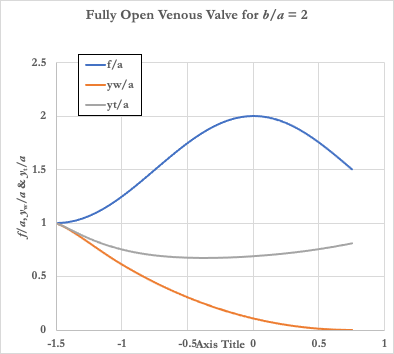